In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info'])


In [13]:
#@ Store (x,y) positions of each neuron
tp = np.zeros(((dat['sresp'].shape[1]),2))
for k in range(dat['sresp'].shape[1]):
    tp[k,:] = np.array([dat['stat'][k]['xpix'].mean(),dat['stat'][k]['ypix'].mean()])

In [55]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
n_cmp = 20
Z = zscore(dat['sresp'], axis=1)
p = PCA(n_components = n_cmp)
p.fit_transform(Z.T)
X = p.components_@Z

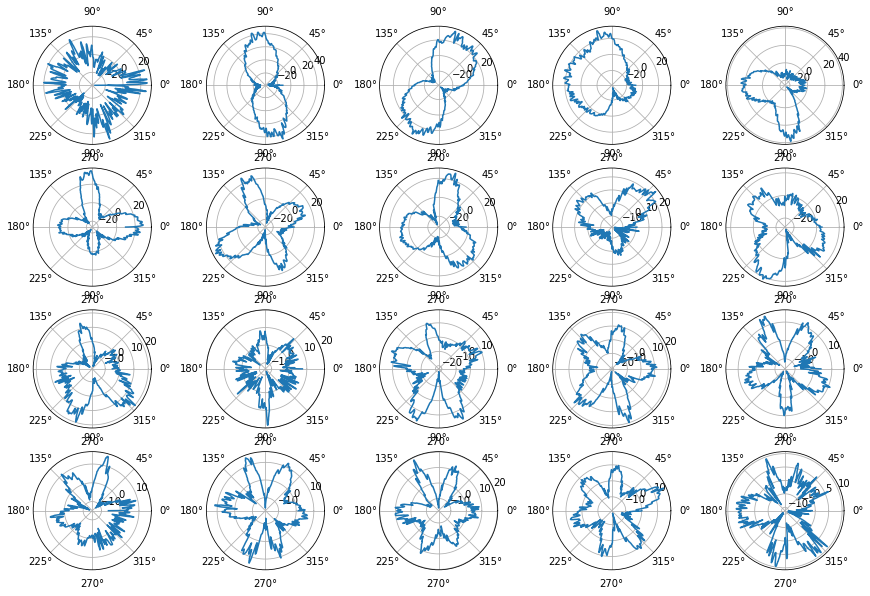

In [100]:
#@ Plot PC response to stimulus angle
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt

b,a = butter(4, [0.05], 'lowpass') #creating a low pass butterworth filter

idx = np.argsort(dat['istim'])
fig = plt.figure(figsize = (15,10))
for j in np.arange(n_cmp):
    fig.add_subplot(4,5,j+1,polar = True)
    plt.plot(dat['istim'][idx],filtfilt(b,a,X[j,idx]))
#     plt.scatter(dat['istim'][idx],X[j,idx])
plt.show()

In [61]:
#@ Split the data into training (2/3) and testing (1/3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, dat['istim'])
print('Training data size = ', X_train.shape)
print('Training target size = ', y_train.shape)
print('Testing data size = ', X_test.shape)
print('Testing target size = ', y_test.shape)

Training data size =  (3448, 20)
Training target size =  (3448,)
Testing data size =  (1150, 20)
Testing target size =  (1150,)


In [98]:

y_train_2d =  np.concatenate((np.cos(y_train), np.sin(y_train))).reshape(len(y_train),2)
y_test_2d =  np.concatenate((np.cos(y_test), np.sin(y_test))).reshape(len(y_test),2)
print(y_train_2d.shape, y_test_2d.shape)

(3448, 2) (1150, 2)


In [66]:
from sklearn.linear_model import LinearRegression
mod = LinearRegression()
mod.fit(X_train, y_train)

LinearRegression()

In [80]:
from sklearn.neural_network import MLPRegressor
mod2 = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(200,1), random_state=1)
mod2.fit(X_train, [np.cos(y_train), np.sin(y_train)])

/Users/uilkitufa/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=(200, 1),
             random_state=1, solver='lbfgs')

Training r^2:  0.91
Testing r^2:  0.46


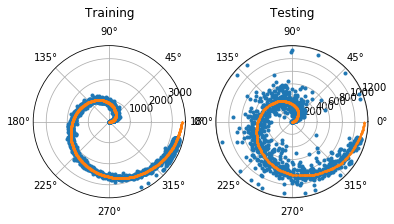

In [102]:
from matplotlib import pyplot as plt
from scipy.stats import circmean, pearsonr
fig = plt.figure()

#@ Training data
idx = np.argsort(y_train.T)
output = mod2.predict(X_train)
fig.add_subplot(1,2,1,polar = True)
plt.polar(output[idx],np.arange(len(output)),'.')
plt.polar(y_train[idx],np.arange(len(output)),'.',markersize = 2, alpha = 1)
plt.title('Training\n')

x = np.sin(output - circmean(output))
y = np.sin(y_train - circmean(y_train))
acc1 = pearsonr(x,y)[0]**2

#@ Testing data
idx = np.argsort(y_test.T)
output = mod2.predict(X_test)
fig.add_subplot(1,2,2,polar = True)
plt.polar(output[idx],np.arange(len(output)),'.')
plt.polar(y_test[idx],np.arange(len(output)),'.',markersize = 2, alpha = 1)
plt.title('Testing\n')

x = np.sin(output - circmean(output))
y = np.sin(y_test - circmean(y_test))
acc2 = pearsonr(x,y)[0]**2

print('Training r^2: ',f'{acc1:.2f}')
print('Testing r^2: ',f'{acc2:.2f}')